# Load Pre-Trained CNN Image Classification Network with Attention
- Load in a pre-trained CNN image classification to leverage transfer learning

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import relevant libraries
import os
import json
import yaml
import nltk
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16        # Load in based VGG16 model
# from keras.preprocessing.image import ImageDataGenerator

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ktrin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# load in the base model
# freeze all the weights (avoid overfitting)
cnn_model = VGG16(input_shape = (224, 224, 3),    # Shape of our images
                    include_top = False,           # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in cnn_model.layers:
    layer.trainable = False
cnn_model.layers

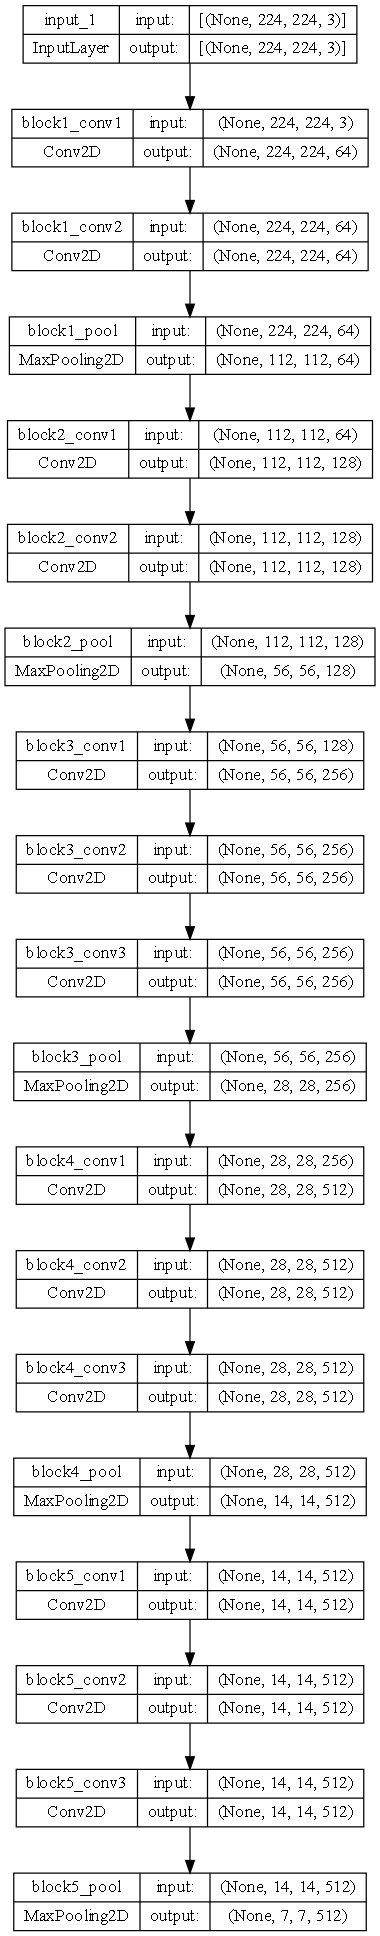

In [5]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [6]:
train2017 = []
val2017 = []

train_file = open("../data/annotations/captions_train2017.json")
val_file = open("../data//annotations/captions_val2017.json")
train_json = json.load(train_file)
val_json = json.load(val_file)
# train_json['caption']

def parse_image(json_data, output_list=train2017, mode="train"):
    """
        Class to parse image into a list of tuple
        -----------------------------------------
        Input:
        - json_data: dataset in json format
        - output_list: empty list to store the tuple of data
        - mode: either train dataset or validation dataset specification
        Output:
        - list of tuple
    """
    prepend_urL = ""
    if mode == "train":
        prepend_urL = "train2017_resized/"
    elif mode == "validation":
        prepend_urL = "val2017_resized/"
    else:
        print("Please Input Train or Validation for dataset parameters")
    
    # fetch the data in a workable format
    captions = json_data['annotations']
    images = {i["id"]: i["file_name"] for i in json_data['images']}

    # parse json data into a tuple to generate a list of tuples for both train/validation
    i = 0
    prev_image_id = 0

    for caption in captions:
        if i == 20000:
            break
        
        image_id = caption['image_id']

        if prev_image_id != image_id:
            i += 1

        image_caption = caption['caption']
        image_url = prepend_urL+images[image_id]
        output_list.append((image_id, image_url, image_caption))
        prev_image_id = image_id

    return output_list


train2017 = parse_image(train_json, output_list=train2017, mode="train")
val2017 = parse_image(val_json, output_list=val2017, mode="validation")
print("Train:\n", train2017[:5])
print("\nValidation:\n", val2017[:5])

Train:
 [(203564, 'train2017_resized/000000203564.jpg', 'A bicycle replica with a clock as the front wheel.'), (322141, 'train2017_resized/000000322141.jpg', 'A room with blue walls and a white sink and door.'), (16977, 'train2017_resized/000000016977.jpg', 'A car that seems to be parked illegally behind a legally parked car'), (106140, 'train2017_resized/000000106140.jpg', 'A large passenger airplane flying through the air.'), (106140, 'train2017_resized/000000106140.jpg', 'There is a GOL plane taking off in a partly cloudy sky.')]

Validation:
 [(179765, 'val2017_resized/000000179765.jpg', 'A black Honda motorcycle parked in front of a garage.'), (179765, 'val2017_resized/000000179765.jpg', 'A Honda motorcycle parked in a grass driveway'), (190236, 'val2017_resized/000000190236.jpg', 'An office cubicle with four different types of computers.'), (331352, 'val2017_resized/000000331352.jpg', 'A small closed toilet in a cramped space.'), (517069, 'val2017_resized/000000517069.jpg', 'Two 

# Load Image Data
Load image data as numpy pixels. Each image contains a caption, append the caption with the respected image in the given list 

In [6]:
DATA_DIR = "../data"

def pil_loader(path):
    """
        Function to load the image into memory
    """
    with open(path, 'r+b') as f:
        img = Image.open(f)
        return img.convert('RGB'), f

# build a list of training data
train_image_data = []
train_caption_data = []
for i in tqdm(train2017):
    img, f = pil_loader(f"{DATA_DIR}/{i[1]}")
    f.close()
    train_image_data.append(np.array(img))
    train_caption_data.append(i[2])


  0%|          | 0/20169 [00:00<?, ?it/s]

In [9]:
train_image_data = np.array(train_image_data)
train_caption_data = np.array(train_caption_data)
print(train_image_data.shape, train_caption_data.shape)

(20169, 224, 224, 3) (20169,)


In [10]:
# output the dataset as a pickle so we don't have to load it everytime
joblib.dump(train_image_data, "image_data.pkl")
joblib.dump(train_caption_data, "image_caption_data.pkl")

['image_caption_data.pkl']

# Data Pre-Processing
Text based data need to be treated:
1. stop word removal
2. tokenized
3. build vocab

In [6]:
# import data
train_image_data = joblib.load("./image_data.pkl")
train_caption_data = joblib.load("./image_caption_data.pkl")

In [7]:
# build a vocabulary using sklearn count vectorizer to create a vocab from the most frequent words
MAX_VOCAB_SIZE = 20000

input_captions = []

max_caption_length = -1 

for caption in tqdm(train_caption_data):
    tokenized_caption = nltk.word_tokenize(caption, language='english')

    if len(tokenized_caption) > max_caption_length:
        max_caption_length = len(tokenized_caption)

    caption = (' '.join(tokenized_caption)).lower()
    input_captions.append(caption)


vectorizer = CountVectorizer(max_features=MAX_VOCAB_SIZE)
vectorizer.fit(input_captions)
vocab = vectorizer.get_feature_names()
MAX_VOCAB_SIZE = len(vocab)

  0%|          | 0/20169 [00:00<?, ?it/s]

C:\Users\ktrin\miniconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
print(len(vocab))

5941


In [9]:
# turn vocab into a dictionary of words and token id
id_vocab_dict = {}
vocab_id_dict = {}

for sid, svocab in enumerate(vocab):
    id_vocab_dict[sid] = svocab
    vocab_id_dict[svocab] = sid

id_vocab_dict[MAX_VOCAB_SIZE] = "<unk>"
id_vocab_dict[MAX_VOCAB_SIZE + 1] = "<start>"
id_vocab_dict[MAX_VOCAB_SIZE + 2] = "<end>"
id_vocab_dict[MAX_VOCAB_SIZE + 3] = "<pad>"

vocab_id_dict["<unk>"] = MAX_VOCAB_SIZE
vocab_id_dict["<start>"] = MAX_VOCAB_SIZE + 1
vocab_id_dict["<end>"] = MAX_VOCAB_SIZE + 2
vocab_id_dict["<pad>"] = MAX_VOCAB_SIZE + 3


In [10]:
# tokenization - take the input caption and tokenize it
# declare a max sequence length 
from concurrent.futures import process


MAX_SEQ_LENGTH = 20 # 18 + start, end
EMBED_DIM = 100 

def convert_text_to_data(texts, 
                         vocab_id_dict, 
                         max_length=20, 
                         type=None,
                         train_test_vector=None):
    """
        Function to convert text based data into tokenized data with proper padding
    """

    processed_data = []
    for text_num, text in enumerate(texts):
        sentence_ids = []

        # split the sentence into token
        # use the vocab to turn the word token into number
        for token in text.split():
            if token in vocab_id_dict.keys():
                sentence_ids.append(vocab_id_dict[token])
            else:
                sentence_ids.append(vocab_id_dict["<unk>"])

        vocab_size = len(vocab_id_dict.keys())

        # for decoder cases:
        # input sentence: <start>, [tokenize words from vocab], <end>, padded with <unk>
        # ouput sentence has: [tokenize words from vocab], <end>, padded with <unk>
        if type == 'input_target':
            ids = ([vocab_size - 3] + sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        elif type == 'output_target':
            ids = (sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        processed_data.append(ids)

    return np.array(processed_data)

train_target_input_data = convert_text_to_data(input_captions,
                                                vocab_id_dict,
                                                type='input_target',
                                                max_length=MAX_SEQ_LENGTH)
                                                
train_target_output_data = convert_text_to_data(input_captions,
                                                vocab_id_dict,
                                                type='output_target',
                                                max_length=MAX_SEQ_LENGTH)

In [11]:
len(vocab_id_dict)

5945

In [12]:
train_target_input_data.shape

(20169, 20)

In [13]:
train_target_output_data.shape

(20169, 20)

In [14]:
# # Testing CNN output
# cnn_model_layer = keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
# cnn_model_layer(train_image_data[0].reshape(1,224,224,3)).shape

# Model Building - CNN + LSTM + Attention

In [15]:
def image_captioning_model(image_shape=(224, 224, 3),
                            caption_shape=MAX_SEQ_LENGTH,
                            vocab_size = len(vocab_id_dict.keys()),
                            embed_dim = EMBED_DIM,
                            encoder_model=cnn_model,
                            hidden_dimensions=[256, 128],
                            dropout_rate=0.3):
    """
        Image captioning model architecture:
            1. ImageNet pretrained CNN model to encode a given image
            2. decoder takes in the CNN image hidden state and run through LSTM
    """

    # Encoder architecture: take in source image, feed through CNN, catch the last pooled pooled layer
    # create the context vecto
    source_image = keras.layers.Input(shape=image_shape, dtype='int64', name='source_image_layer')
    cnn_model_layer = keras.Model(inputs=encoder_model.input, outputs=encoder_model.layers[-2].output)
    source_image_encoding = cnn_model_layer(source_image)
    annotation_vector = keras.layers.Reshape(target_shape=(196, 512), 
                                             input_shape=(None, 14, 14, 512),
                                             name='filter_reshape_layer')(source_image_encoding)

        
    # Decoder architecture: take in encoder output, feed through LSTM, apply attention (as needed)
    caption = keras.layers.Input(shape=(caption_shape,), dtype='int64', name='source_caption_layer')
    embedding_layer  = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                name='caption_embedding_layer')

    embed_caption = embedding_layer(caption)
    lstm_layer = keras.layers.LSTM(512, return_sequences=True, return_state=True, name="decoder_lstm_layer")
    decoder_output, decoder_state_h_output, decoder_state_c_output = lstm_layer(embed_caption)
    last_hidden_output = decoder_output
    
    # apply attention, Apply attention to the decoder output
    attention_context_vectors = keras.layers.MultiHeadAttention(num_heads=10,
                                                                key_dim=20,
                                                                name='multi_headed_attention_layer')(decoder_output, annotation_vector)
    concat_decode_out_with_att = keras.layers.Concatenate(axis=-1, name='concat_layer_with_att')([decoder_output, attention_context_vectors])
    last_hidden_output = concat_decode_out_with_att

#     # add a fully connected feed-forward net
#     # some final dropout layer
#     # add final classification layer
#     for hidden_layer_size in hidden_dimensions:
#         last_hidden_output = keras.layers.Dense(hidden_layer_size, activation='relu')(last_hidden_output)

#     last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)

    caption_output = keras.layers.Dense(vocab_size, activation='softmax', name="output_layer")(last_hidden_output)

    # instantiate and compile the model
    model = keras.Model(inputs=[source_image, caption], outputs=[caption_output])
    model.compile(optimizer='Adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
    
    return model

    

In [16]:
img_cap_model = image_captioning_model()
img_cap_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_caption_layer (InputLay  [(None, 20)]        0           []                               
 er)                                                                                              
                                                                                                  
 source_image_layer (InputLayer  [(None, 224, 224, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 caption_embedding_layer (Embed  (None, 20, 100)     594500      ['source_caption_layer[0][0]']   
 ding)                                                                                      

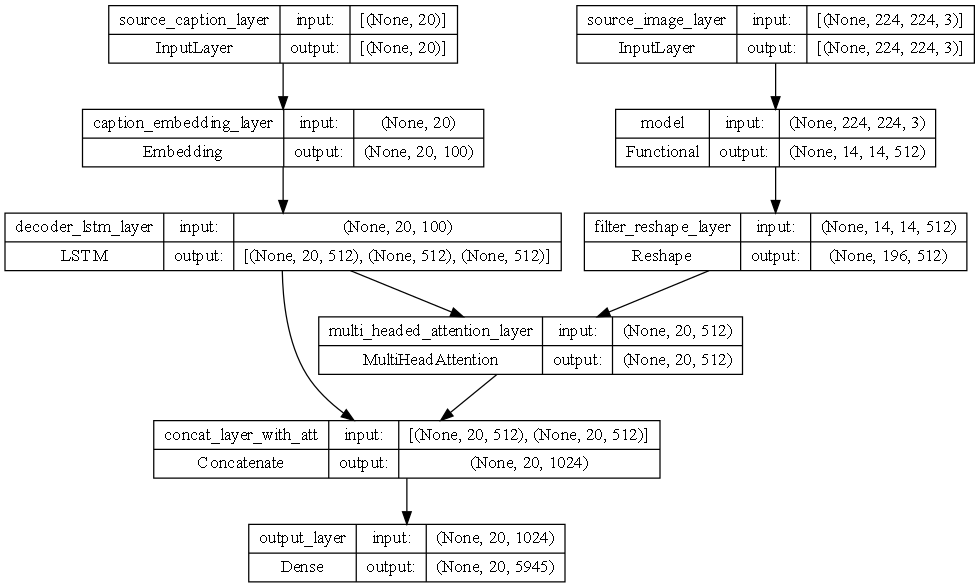

In [17]:
keras.utils.plot_model(img_cap_model, show_shapes=True, dpi=90)

In [18]:
train_target_output_data.shape

(20169, 20)

In [19]:
img_cap_model.fit(x=[train_image_data, train_target_input_data],
                    y=train_target_output_data,
                    validation_split=0.1,
                    batch_size=16,
                    epochs=20)

Epoch 1/20
1135/1135 [==============================] - 132s 109ms/step - loss: 2.4666 - accuracy: 0.5812 - val_loss: 2.0492 - val_accuracy: 0.6244
Epoch 2/20
1135/1135 [==============================] - 120s 106ms/step - loss: 1.8948 - accuracy: 0.6382 - val_loss: 1.9144 - val_accuracy: 0.6406
Epoch 3/20
1135/1135 [==============================] - 120s 106ms/step - loss: 1.6820 - accuracy: 0.6568 - val_loss: 1.8759 - val_accuracy: 0.6479
Epoch 4/20
1135/1135 [==============================] - 120s 106ms/step - loss: 1.5382 - accuracy: 0.6703 - val_loss: 1.8662 - val_accuracy: 0.6554
Epoch 5/20
1135/1135 [==============================] - 121s 107ms/step - loss: 1.4227 - accuracy: 0.6830 - val_loss: 1.8741 - val_accuracy: 0.6536
Epoch 6/20
1135/1135 [==============================] - 121s 107ms/step - loss: 1.3187 - accuracy: 0.6959 - val_loss: 1.8861 - val_accuracy: 0.6556
Epoch 7/20
1135/1135 [==============================] - 121s 107ms/step - loss: 1.2250 - accuracy: 0.7107 - val_

In [20]:
img_cap_model.save("../data/models/image-captioning-attention.h5")

# Setting Model for Inference
The trained model need to be set up in a way that we don't actually feed in the sentence seeds

In [21]:
img_cap_model = keras.models.load_model('../data/models/image-captioning-attention.h5')
img_cap_model.layers

In [28]:
def inference_model(img_cap_model, vocab_size):
  
    # encoder layer: use the original cnn to encode the image, i guess
    source_image = keras.layers.Input(shape=(224,224,3), dtype='int64', name='source_image_layer')
    cnn_layer = img_cap_model.get_layer('model')(source_image)
    cnn_filters = img_cap_model.get_layer('filter_reshape_layer')(cnn_layer)
    encoder_model = keras.Model(inputs = source_image,  outputs = tf.convert_to_tensor(cnn_filters, dtype='float32'))


    
    # decoder layer
    decoder_inputs = keras.layers.Input(shape=(1,), dtype='float32', name='decoder_initial_state')
    embedding_layer = img_cap_model.get_layer('caption_embedding_layer')
    decoder_lstm = img_cap_model.get_layer('decoder_lstm_layer')
    decoder_attention_layer = img_cap_model.get_layer('multi_headed_attention_layer')
    attention_concat_layer = img_cap_model.get_layer('concat_layer_with_att')
    decoder_outputs_layer = img_cap_model.get_layer('output_layer')

    # declare the image annotation vector
    image_annotion_vector = keras.layers.Input(shape=(196,512))
    
    # compute the embedding for the decoder
    embed_decoder = embedding_layer(decoder_inputs)

    # compute the LSTM ouptuts 
    decoder_outputs, state_h, state_c = decoder_lstm(embed_decoder)
    
    # compute the attention context vector
    attention_output_c = decoder_attention_layer(decoder_outputs, image_annotion_vector)
    attention_concat_layer = attention_concat_layer([decoder_outputs, attention_output_c])
    
    # compute the model output
    decoder_outputs = decoder_outputs_layer(attention_concat_layer)

    # compile the decoder model
    decoder_model = keras.Model(inputs=[decoder_inputs, image_annotion_vector], 
                              outputs=decoder_outputs, name='decoder_model')
    
    return encoder_model, decoder_model



In [29]:
encoder_model, decoder_model = inference_model(img_cap_model, len(id_vocab_dict.keys()))


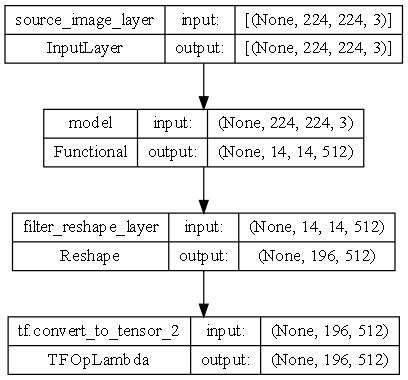

In [30]:
keras.utils.plot_model(encoder_model, show_shapes=True, dpi=90)

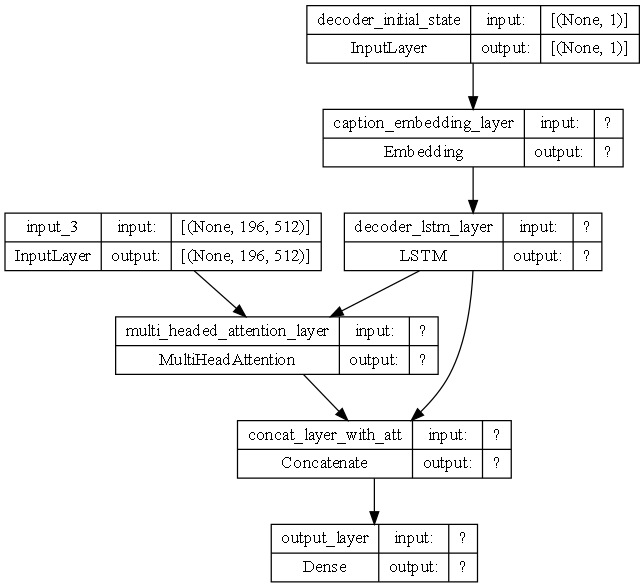

In [31]:
keras.utils.plot_model(decoder_model, show_shapes=True, dpi=90)

In [33]:
# Experimenting with image encoding trained model
# states_value = encoder_model.predict(train_image_data[1].reshape(1,224,224,3))
source_image = keras.layers.Input(shape=(224,224,3), dtype='int64', name='source_image_layer')
cnn_layer = img_cap_model.get_layer('model')(source_image)
cnn_filters = img_cap_model.get_layer('filter_reshape_layer')(cnn_layer)
encoder_model = keras.Model(inputs = source_image,  outputs = tf.convert_to_tensor(cnn_filters, dtype='float32'))


# source_image(train_image_data[1].reshape(1,224,224,3))
test = encoder_model.predict(train_image_data[1].reshape(1,224,224,3))
test = tf.convert_to_tensor(test, dtype='float32')
test.shape

1/1 [==============================] - 0s 192ms/step


TensorShape([1, 196, 512])

In [36]:
# Generate empty target sequence of length 1.
target_seq = np.zeros((1, 20))

# Populate the first character of target sequence with the start character.
target_seq[0, 0] = int(vocab_id_dict['<start>'])
target_seq = tf.convert_to_tensor(target_seq, dtype='float32')

# embedding_layer = img_cap_model.get_layer('caption_embedding_layer')
# embed_decoder = embedding_layer(target_seq)
# decoder_lstm = img_cap_model.get_layer('decoder_lstm_layer')
# decoder_value, state_h, state_c = decoder_lstm(embed_decoder, [test, test])

# define the layers
embedding_layer = img_cap_model.get_layer('caption_embedding_layer')
decoder_lstm = img_cap_model.get_layer('decoder_lstm_layer')
decoder_attention_layer = img_cap_model.get_layer('multi_headed_attention_layer')
attention_concat_layer = img_cap_model.get_layer('concat_layer_with_att')
decoder_outputs_layer = img_cap_model.get_layer('output_layer')

# declare the image annotation vector
image_annotion_vector = keras.layers.Input(shape=(196,512))

# compute the embedding and then feed it through LSTM ouptuts 
embed_decoder = embedding_layer(target_seq)
decoder_outputs, state_h, state_c = decoder_lstm(embed_decoder)

# compute the attention context vector
attention_output_c = decoder_attention_layer(decoder_outputs, image_annotion_vector)
attention_concat_layer = attention_concat_layer([decoder_outputs, attention_output_c])

decoder_outputs = decoder_outputs_layer(attention_concat_layer)

decoder_outputs.shape

TensorShape([1, 20, 5945])

In [37]:
def caption_image(image):
    # instantiate the model
    encoder_model, decoder_model = inference_model(img_cap_model, len(id_vocab_dict.keys()))

    # Encode the input as state vectors.
    image_state = encoder_model.predict(image)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = vocab_id_dict['<start>']
    eos = vocab_id_dict['<end>']


    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    i = 1
    
    while not stop_condition:
        output_tokens = decoder_model.predict([target_seq, image_state])

        # Sample a token
        idx = np.argmax(output_tokens[0, -1])
        
        # Exit condition: either hit max length
        # or find stop character.
        if ( len(decoded_sentence) > 20 ) or eos == idx:
            stop_condition = True
            break
        
            
        if idx > 0:
            sampled_token = id_vocab_dict[idx]
            decoded_sentence.append(sampled_token)
            
        # Update the target sequence (of length 1).
        # target_seq = np.zeros((1, len(vocab_id_dict.keys())))
        target_seq[0, 0] = idx
                
        # increase by 1
        i+=1

    return " ".join(decoded_sentence)

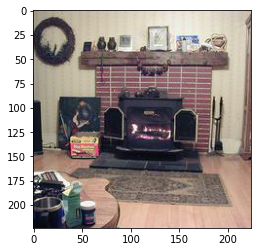

In [41]:
plt.imshow(train_image_data[512])

In [40]:
caption = caption_image(train_image_data[512].reshape(1,224,224,3))
caption

1/1 [==============================] - 0s 25ms/step


'<unk> room with <unk> room with <unk> room with <unk> room with <unk> room with <unk> room with <unk> room with'